In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import nengo

Let's implement a self-organizing map in Nengo.  We'll be basing this on the tutorial at http://blog.yhat.com/posts/self-organizing-maps-2.html

First, we generate our data.  For this example we'll use a 3-dimensional input, since that's easy to visualize as colour.

In [100]:
data = np.random.uniform(0,1, (100,3))

Now we implement the self-organizing map.  Since this requires implementing our own learning rule, we'll have to add our own python code to do this.

The way to add python code to Nengo is with a `nengo.Node`.  We commonly show examples of putting just a function into a Node, but here we also want state (the weights), so we can do the advanced version of a `nengo.Node` which is to put a `nengo.Process` into the `nengo.Node`.  The `nengo.Process` is just a way of encapsulating code and tying into the builder in a cleaner way.

Here's the SOM algorithm implemented as a `nengo.Process`.

In [102]:
class SelfOrganizingMap(nengo.Process):
    def __init__(self, weights, learning_rate=1e1, influence_sigma=1.5):
        self.weights = weights        
        self.learning_rate = learning_rate
        self.influence_sigma = influence_sigma
        
        super().__init__(default_size_in=weights.shape[2],
                         default_size_out=weights.shape[0]*weights.shape[1])
    def make_step(self, shape_in, shape_out, dt, rng, state=None):
        # this called during the build process, so any computationally expensive
        #  pre-processing should be done here.  There isn't really much for an SOM,
        #  but we can pre-generate the distance matrix to speed that part up
        
        pos = np.array(np.meshgrid(np.arange(self.weights.shape[1]), 
                                   np.arange(self.weights.shape[0])))
        
        def step_som(t, x, w=self.weights, pos=pos, 
                     sigma=self.influence_sigma,
                     learning_rate=self.learning_rate):
            # this will be called every timestep, with x as the current input
            
            # first, find the closest element in the map
            diff = np.sum((w - x[None,None,:])**2, axis=2)            
            best = np.argmin(diff)
            best = np.array([best % diff.shape[1], best // diff.shape[1]])
            #assert diff[best[1],best[0]] == np.min(diff)
            
            # now compute how much to influence the elements
            dist = np.sum((pos - best[:,None,None])**2, axis=0)
            influence = np.exp(-dist/(2*sigma**2))
            
            # update the weights
            w += learning_rate * dt * influence[:,:,None] * (x - w)
            
            # the output from the map every timestep will just be the influence
            return influence.flatten()
            
        return step_som



Now let's try it out.   Let's start with a randomly generated set of weights

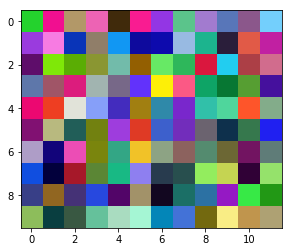

In [103]:
w = np.random.uniform(0, 1, (10, 12, 3))
plt.imshow(w)

Now we present things to the network

In [104]:
model = nengo.Network()
with model:
    stim = nengo.Node(nengo.processes.PresentInput(data, presentation_time=0.001))
    
    som = nengo.Node(SelfOrganizingMap(w))
    nengo.Connection(stim, som, synapse=None)
    p = nengo.Probe(som)
    
sim = nengo.Simulator(model)
sim.run(10)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

And plot the resulting map

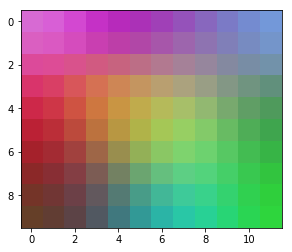

In [105]:
plt.imshow(w)